In [19]:
from doctest import testsource

import pandas as pd
import numpy as np
import random, copy
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup, \
    pipeline
from torch.optim import AdamW
from sklearn.metrics import f1_score
from sklearn.utils import resample
import nltk
from nltk.corpus import wordnet, stopwords
from transformers import logging
import matplotlib.pyplot as plt
import os

logging.set_verbosity_error()

# Download NLTK data (WordNet for synonyms, stopwords list)
nltk.download('wordnet')
nltk.download('stopwords')
# Data augmentation: Synonym Replacement
stop_words = set(stopwords.words('english'))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\24983\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\24983\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load and explore the dataset
We load the data and analyze the distribution of labels, paragraph lengths, and label distributions per keyword and country. We also examine some examples of patronizing paragraphs, especially those with label 4 (highly patronizing).

In [20]:
df = pd.read_csv('./data/dontpatronizeme_pcl.tsv', sep='\t', header=None,
                 names=["par_id", "art_id", "keyword", "country", "paragraph", "orig_label"], skiprows=4)
df['label'] = df['orig_label'].apply(lambda x: 1 if x >= 2 else 0)

df.info

<bound method DataFrame.info of        par_id      art_id     keyword country  \
0           1  @@24942188    hopeless      ph   
1           2  @@21968160     migrant      gh   
2           3  @@16584954   immigrant      ie   
3           4   @@7811231    disabled      nz   
4           5   @@1494111     refugee      ca   
...       ...         ...         ...     ...   
10464   10465  @@14297363       women      lk   
10465   10466  @@70091353  vulnerable      ph   
10466   10467  @@20282330     in-need      ng   
10467   10468  @@16753236    hopeless      in   
10468   10469  @@16779383    homeless      ie   

                                               paragraph  orig_label  label  
0      We 're living in times of absolute insanity , ...           0      0  
1      In Libya today , there are countless number of...           0      0  
2      White House press secretary Sean Spicer said t...           0      0  
3      Council customers only signs would be displaye...           

orig_label
0    8529
1     947
2     144
3     458
4     391
Name: count, dtype: int64


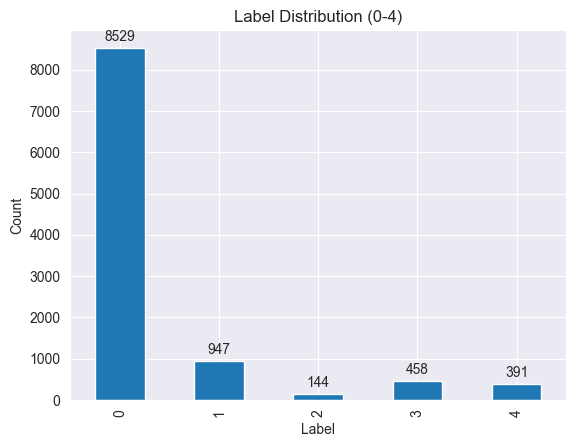

Binary distribution:
 label
0    9476
1     993
Name: count, dtype: int64


In [21]:

# Distribution of original 5 labels (0–4)
label_counts = df["orig_label"].value_counts().sort_index()
print(label_counts)

# Plot distribution
fig, ax = plt.subplots()
label_counts.plot(kind="bar", ax=ax, title="Label Distribution (0-4)")
ax.set_xlabel("Label")
ax.set_ylabel("Count")

for p in ax.patches:
    ax.annotate(
        str(int(p.get_height())),
        xy=(p.get_x() + p.get_width() / 2., p.get_height()),
        xytext=(0, 3),
        textcoords="offset points",
        ha='center', va='bottom'
    )

plt.show()

# Convert to binary (0,1), i.e. labels >=2 are PCL
binary_counts = df["label"].value_counts()
print("Binary distribution:\n", binary_counts)

Average paragraph length by label:
 orig_label
0    47.418103
1    52.019007
2    49.104167
3    51.556769
4    57.700767
Name: para_length, dtype: float64


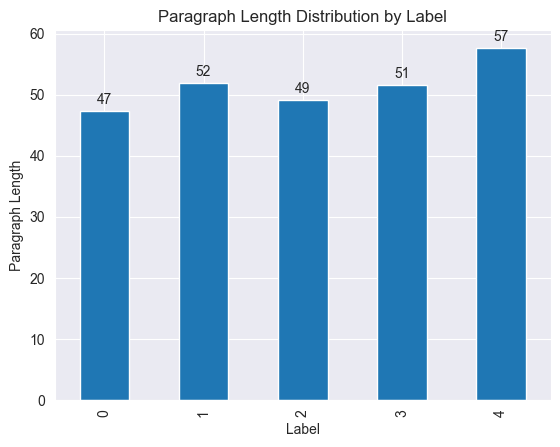

In [37]:
df["str_paragraph"] = df["paragraph"].astype(str).fillna("")


df["para_length"] = df["str_paragraph"].apply(lambda x: len(x.split()))
# Group by label, compute mean or median paragraph length
length_by_label = df.groupby("orig_label")["para_length"].mean()
print("Average paragraph length by label:\n", length_by_label)

# Plot length distributions
fig, ax = plt.subplots()
length_by_label.plot(kind="bar", ax=ax, title="Paragraph Length Distribution by Label")
ax.set_xlabel("Label")
ax.set_ylabel("Paragraph Length")

for p in ax.patches:
    ax.annotate(
        str(int(p.get_height())),
        xy=(p.get_x() + p.get_width() / 2., p.get_height()),
        xytext=(0, 3),
        textcoords="offset points",
        ha='center', va='bottom'
    )

plt.show()


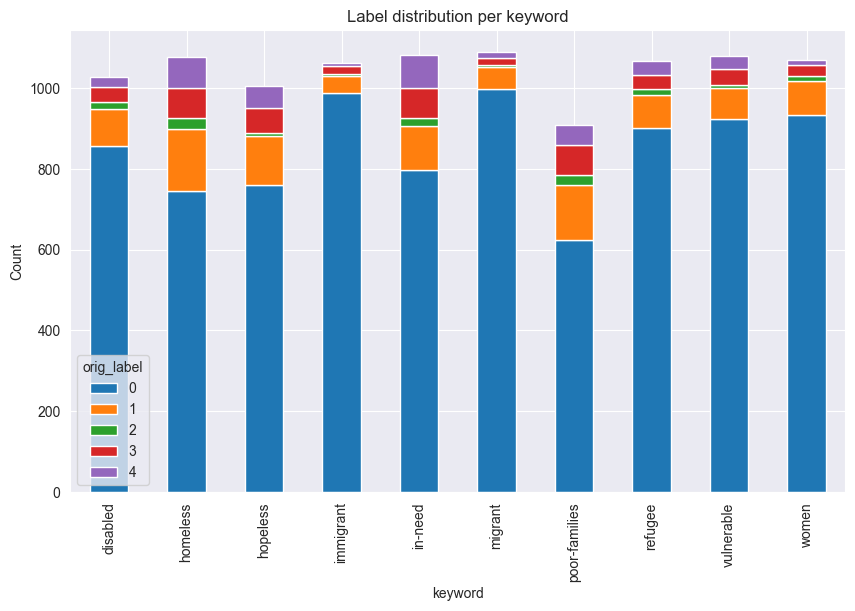

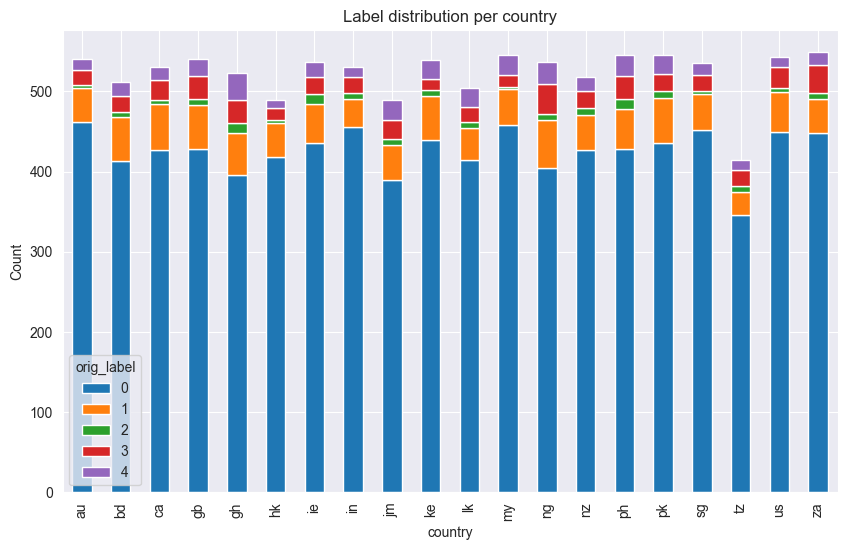

In [23]:
pd.crosstab(df["keyword"], df["orig_label"]).plot(kind="bar", stacked=True, figsize=(10,6))
plt.title("Label distribution per keyword")
plt.ylabel("Count")
plt.show()

pd.crosstab(df["country"], df["orig_label"]).plot(kind="bar", stacked=True, figsize=(10,6))
plt.title("Label distribution per country")
plt.ylabel("Count")
plt.show()

In [24]:
import random

for lbl in [0,1,2,3,4]:
    subset = df[df["orig_label"] == lbl]
    example = subset.sample(1, random_state=10)
    print(f"\nLabel {lbl} example:")
    print(example["paragraph"].values[0], "\n")

# Note: The data was annotated by multiple annotators (leading to 0–4 labels). Observing paragraphs with label=1 or label=2 often reveals partial disagreements or borderline cases.
# Examine paragraphs that were assigned label 4 (highly patronizing). Are they obviously condescending or do they also have borderline tones?



Label 0 example:
It was time and again mentioned that Pakistan Squash Federation ( PSF ) must wake up from deep slump and pay proper attention towards women squash , but no heed was paid and the result is evident that except Canadian-based Pakistani Maria , all women squash players were thrown out of the event . The PSF must start work on female squash promotion on war footings , or else just ask females to forget about playing international squash . 


Label 1 example:
The first time MP , who is a holder of Bachelor in Medicine and Bachelor in Surgery from the University of Nairobi , has in the past decried how women often shun disabled man . He is also on record for paying tribute to his wife , a nurse , for taking care of him all though . 


Label 2 example:
" A mass protest was held in Jaffna at 3 p.m. yesterday against Tamil Nadu politicians Thol . Thiruvmavalavan , T. Velmurugan and Y. Gopalaswamy , who prevented the superstar of Tamil cinema , Rajinikanth , visiting Jaffna to h

The result shows that the data set is highly imbalanced, with the majority of paragraphs labeled as 0 (not patronizing) and only a small fraction labeled as 1 (patronizing). The average paragraph length is similar across labels.

### Data Augmentation and Balancing
We will augment the training data by applying two techniques: synonym replacement and back-translation. Synonym replacement replaces words in the text with synonyms, while back-translation translates the text to another language and back to the original language. These techniques can help improve model generalization and robustness.

In [25]:
# Set random seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def synonym_replacement(sentence, n=1):
    words = sentence.split()
    new_words = words.copy()
    # Identify candidate words (non-stopwords, alphabetic only)
    candidates = [i for i, w in enumerate(words) if w.lower() not in stop_words and w.isalpha()]
    random.shuffle(candidates)
    replaced = 0
    for idx in candidates:
        if replaced >= n:
            break
        synonyms = set()
        for syn in wordnet.synsets(words[idx]):
            for lemma in syn.lemmas():
                if lemma.name().lower() != words[idx].lower():
                    synonyms.add(lemma.name().replace('_', ' '))
        if synonyms:
            new_words[idx] = random.choice(list(synonyms))
            replaced += 1
    return " ".join(new_words)

translator_en_to_es = pipeline("translation_en_to_es", model="Helsinki-NLP/opus-mt-en-es", device=-1)
translator_es_to_en = pipeline("translation_es_to_en", model="Helsinki-NLP/opus-mt-es-en", device=-1)

def back_translate(sentence):
    try:
        es_text = translator_en_to_es(sentence, max_length=MAX_LENGTH)[0]['translation_text']
        back_text = translator_es_to_en(es_text, max_length=MAX_LENGTH)[0]['translation_text']
        return back_text
    except Exception as e:
        return sentence  # fallback to original if translation fails


# Augment training data (apply to minority class samples)
def augment_data(df):
    augmented_texts = []
    augmented_labels = []
    for _, row in df[df['label'] == 1].iterrows():
        text = row['paragraph']
        # Synonym replacement augmentation
        aug_text1 = synonym_replacement(text, n=1)
        # Back-translation augmentation
        aug_text2 = back_translate(text)
        augmented_texts.extend([aug_text1, aug_text2])
        augmented_labels.extend([1, 1])
    aug_df = pd.DataFrame({'paragraph': augmented_texts, 'label': augmented_labels})
    # Combine augmented samples with original data
    return pd.concat([df, aug_df], ignore_index=True)


# Oversample minority class to balance the dataset
def oversample_data(df):
    df_majority = df[df['label'] == 0]
    df_minority = df[df['label'] == 1]
    if len(df_minority) == 0 or len(df_majority) == 0:
        return df
    if len(df_minority) < len(df_majority):
        df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=0)
        df_balanced = pd.concat([df_majority, df_minority_upsampled], ignore_index=True)
    else:
        df_majority_upsampled = resample(df_majority, replace=True, n_samples=len(df_minority), random_state=0)
        df_balanced = pd.concat([df_minority, df_majority_upsampled], ignore_index=True)
    # Shuffle after oversampling
    df_balanced = df_balanced.sample(frac=1, random_state=0).reset_index(drop=True)
    return df_balanced

In [26]:
from sklearn.model_selection import train_test_split

train_df, test_val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=0)
test_df, val_df = train_test_split(test_val_df, test_size=0.5, stratify=test_val_df['label'], random_state=0)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(train_df.head())
print(train_df.info())

   par_id      art_id        keyword country  \
0    1046  @@19202846      immigrant      bd   
1    3020  @@23325397  poor-families      hk   
2    4243   @@8774436        in-need      gb   
3    7858   @@8634994     vulnerable      ng   
4    2549   @@2688379          women      au   

                                           paragraph  orig_label  label  \
0  Many advocates for immigrants say they are hop...           0      0   
1  Dozens of children and parents from poor famil...           0      0   
2  No one was injured in the incident although th...           0      0   
3  " Owing to this drought and the on-going water...           0      0   
4  " It is only a matter of luck that Ms Stevens ...           1      0   

                                       str_paragraph  para_length  
0  Many advocates for immigrants say they are hop...           29  
1  Dozens of children and parents from poor famil...           67  
2  No one was injured in the incident although th...    

In [27]:
train_df = train_df.dropna(subset=['paragraph'])
train_df['paragraph'] = train_df['paragraph'].astype(str)

try:

    # If you've already saved train_augmented_oversampled.csv
    train_df_final = pd.read_csv("./example_training_data/train_augmented_oversampled.csv")
    val_df = pd.read_csv("./example_training_data/val.csv")
    test_df = pd.read_csv("./example_training_data/test.csv")
except:

    # Augment and balance training data
    train_df_aug = augment_data(train_df)
    train_df_final = oversample_data(train_df_aug)
    for idx, row in train_df.iterrows():
        if not isinstance(row['paragraph'], str):
            print(f"Row {idx} has invalid type: {type(row['paragraph'])}, value = {row['paragraph']}")

    train_df_final.to_csv("./example_training_data/train_augmented_oversampled.csv", index=False)
    val_df.to_csv("./example_training_data/val.csv", index=False)
    test_df.to_csv("./example_training_data/test.csv", index=False)

train_df_final.info


<bound method DataFrame.info of         par_id      art_id    keyword country  \
0          NaN         NaN        NaN     NaN   
1      10269.0  @@15357075   homeless      gb   
2          NaN         NaN        NaN     NaN   
3       2214.0  @@24216252  immigrant      ie   
4          NaN         NaN        NaN     NaN   
...        ...         ...        ...     ...   
15155      NaN         NaN        NaN     NaN   
15156   7317.0  @@20518391    in-need      in   
15157      NaN         NaN        NaN     NaN   
15158      NaN         NaN        NaN     NaN   
15159   9380.0  @@21676447  immigrant      hk   

                                               paragraph  orig_label  label  
0      Watching poor families in England writhe in pa...         NaN      1  
1      Veterans left on scrapheap : The homeless plig...         4.0      1  
2      After a tragic event during his previous life ...         NaN      1  
3      Labour said it was " truly shocking " that the...         0.

label
0    7580
1    7580
Name: count, dtype: int64


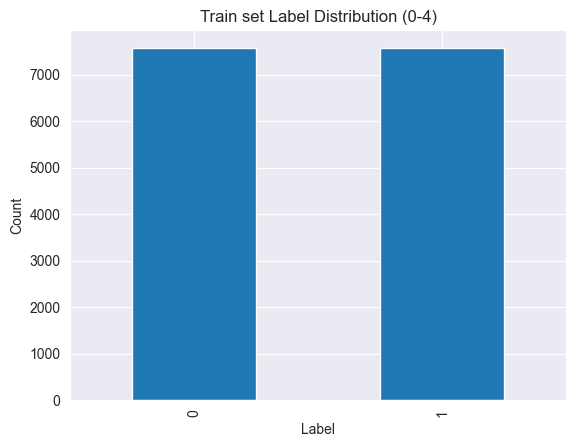

label
0    947
1    100
Name: count, dtype: int64


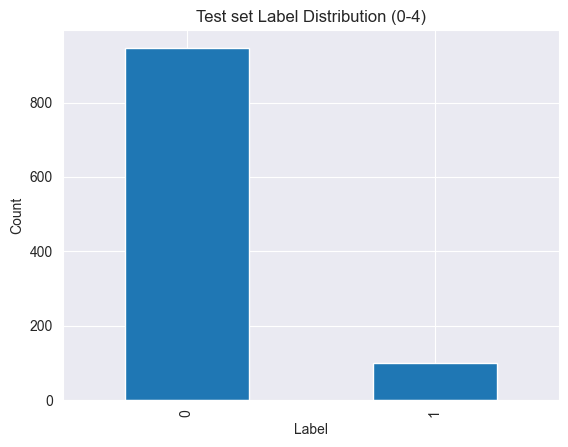

In [28]:
# Distribution of original 5 labels (0–4)
label_counts = train_df_final["label"].value_counts().sort_index()
print(label_counts)

# Plot distribution
label_counts.plot(kind="bar", title="Train set Label Distribution (0-4)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# Distribution of original 5 labels (0–4)
label_counts = test_df["label"].value_counts().sort_index()
print(label_counts)

# Plot distribution
label_counts.plot(kind="bar", title="Test set Label Distribution (0-4)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

### Training and Evaluation



In [29]:
MODEL_NAME = 'roberta-base'
MAX_LENGTH = 256
BATCH_SIZE = 16
NUM_EPOCHS = 10
PATIENCE = 3
WARMUP_PROPORTION = 0.1
LR_CANDIDATES = [1e-5, 2e-5, 5e-5]
ENSEMBLE_SEEDS = [42, 52, 62]

In [30]:
# Create DataLoader for a given DataFrame
def build_dataloader(df, tokenizer, batch_size, shuffle=False):
    texts = list(df['paragraph'])
    encodings = tokenizer(texts, padding='max_length', truncation=True, max_length=MAX_LENGTH, return_tensors='pt')
    if 'label' in df.columns:
        labels = torch.tensor(df['label'].values, dtype=torch.long)
        dataset = TensorDataset(encodings['input_ids'], encodings['attention_mask'], labels)
    else:
        dataset = TensorDataset(encodings['input_ids'], encodings['attention_mask'])
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=True)


# Training function for one model
def train_model(train_loader, val_loader, learning_rate, class_weights_tensor, num_epochs=NUM_EPOCHS, patience=PATIENCE, seed=42):
    set_seed(seed)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-2)
    total_steps = num_epochs * len(train_loader)
    warmup_steps = int(WARMUP_PROPORTION * total_steps)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,
                                                num_training_steps=total_steps)
    scaler = torch.amp.GradScaler()
    best_f1 = 0.0
    best_state = None
    epochs_no_improve = 0

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss = 0.0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            # Forward pass (with mixed precision)
            with torch.amp.autocast(device_type='cuda'):
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                loss_fct = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))
                loss = loss_fct(logits, labels)
            # Backward pass and optimization
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            total_loss += loss.item()
        # Validation phase
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch[0].to(device)
                attention_mask = batch[1].to(device)
                labels = batch[2].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                preds = torch.argmax(outputs.logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        val_f1 = f1_score(all_labels, all_preds, average='binary')
        print(f"Epoch {epoch}/{num_epochs} - Loss: {total_loss / len(train_loader):.4f} - Val F1: {val_f1:.4f}")
        # Check for improvement
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                break

    # Load best weights and return model
    if best_state is not None:
        model.load_state_dict(best_state)
    model.eval()
    return model, best_f1

In [31]:
from sklearn.utils.class_weight import compute_class_weight

# (B) Compute class weights if data is imbalanced
# If truly balanced, you might skip or set them to [1.0, 1.0].
train_labels = train_df['label'].values
# This uses scikit-learn to automatically compute
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights[1] = class_weights[1] * 0.5
# Convert to torch tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

class_weights_tensor

tensor([0.5524, 2.6366])

In [32]:
train = True

# Tokenize and create DataLoaders
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
train_loader = build_dataloader(train_df, tokenizer, batch_size=BATCH_SIZE, shuffle=True)
val_loader = build_dataloader(val_df, tokenizer, batch_size=BATCH_SIZE, shuffle=False)
test_loader = build_dataloader(test_df, tokenizer, batch_size=BATCH_SIZE,
                               shuffle=False) if test_df is not None else None

try:
    if train:
        raise Exception
    ensemble_models = []
    n_models = 3  # how many you saved
    for i in range(n_models):
        load_dir = f'ensemble_model_{i}'
        model = AutoModelForSequenceClassification.from_pretrained(load_dir)
        model.to(device)
        tokenizer = AutoTokenizer.from_pretrained(load_dir)
        ensemble_models.append(model)
        print("Loaded model from", load_dir)
except:

    # Hyperparameter tuning (learning rate)
    best_lr = None
    best_val_f1 = 0.0
    print("Hyperparameter tuning for learning rate...")
    for lr in LR_CANDIDATES:
        print(f"Training with lr={lr}")
        model, val_f1 = train_model(train_loader, val_loader, class_weights_tensor=class_weights_tensor, learning_rate=lr, num_epochs=3, patience=2, seed=42)
        print(f"Val F1 = {val_f1:.4f} for lr={lr}")
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_lr = lr
        # Free GPU memory before next trial
        del model
        torch.cuda.empty_cache()
    print(f"Best LR: {best_lr}, Val F1: {best_val_f1:.4f}")

    # Train ensemble models with best hyperparameters
    ensemble_models = []
    for seed in ENSEMBLE_SEEDS:
        print(f"Training model with seed {seed} (lr={best_lr})...")
        model, val_f1 = train_model(train_loader, val_loader, class_weights_tensor=class_weights_tensor, learning_rate=best_lr, num_epochs=NUM_EPOCHS,
                                    patience=PATIENCE, seed=seed)
        print(f"Model seed {seed} Val F1 = {val_f1:.4f}")
        ensemble_models.append(model)

    for i, model in enumerate(ensemble_models):
        save_dir = f'ensemble_model_{i}'
        # model is a standard huggingface model derived from AutoModelForSequenceClassification
        model.save_pretrained(save_dir)
        # Also save tokenizer if you want a self-contained folder
        tokenizer.save_pretrained(save_dir)


# increase patience. 3 is too low when we have a high weight and things might be learnt slowly

Hyperparameter tuning for learning rate...
Training with lr=1e-05
Epoch 1/3 - Loss: 0.4898 - Val F1: 0.4866
Epoch 2/3 - Loss: 0.3108 - Val F1: 0.5873
Epoch 3/3 - Loss: 0.2024 - Val F1: 0.5507
Val F1 = 0.5873 for lr=1e-05
Training with lr=2e-05
Epoch 1/3 - Loss: 0.4917 - Val F1: 0.5096
Epoch 2/3 - Loss: 0.3089 - Val F1: 0.5387
Epoch 3/3 - Loss: 0.1715 - Val F1: 0.5692
Val F1 = 0.5692 for lr=2e-05
Training with lr=5e-05
Epoch 1/3 - Loss: 0.5868 - Val F1: 0.0000
Epoch 2/3 - Loss: 0.6034 - Val F1: 0.0000
Early stopping triggered.
Val F1 = 0.0000 for lr=5e-05
Best LR: 1e-05, Val F1: 0.5873
Training model with seed 42 (lr=1e-05)...
Epoch 1/10 - Loss: 0.5245 - Val F1: 0.5275
Epoch 2/10 - Loss: 0.3466 - Val F1: 0.5507
Epoch 3/10 - Loss: 0.2191 - Val F1: 0.6174
Epoch 4/10 - Loss: 0.1389 - Val F1: 0.5641
Epoch 5/10 - Loss: 0.0826 - Val F1: 0.5617
Epoch 6/10 - Loss: 0.0577 - Val F1: 0.5700
Early stopping triggered.
Model seed 42 Val F1 = 0.6174
Training model with seed 52 (lr=1e-05)...
Epoch 1/10

In [33]:
all_dev_test_preds = []
for model in ensemble_models:
    model.eval()
    preds = []
    with torch.no_grad():
        for batch in test_loader:  # val_loader is a DataLoader object
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            batch_preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            preds.extend(batch_preds)
    all_dev_test_preds.append(preds)

# Transpose and vote
all_dev_test_preds = np.array(all_dev_test_preds)  # shape: (num_models, num_examples)
ensemble_dev_test_preds = []
for j in range(all_dev_test_preds.shape[1]):
    votes = np.sum(all_dev_test_preds[:, j])
    ensemble_dev_test_preds.append(1 if votes > len(ensemble_models) / 2 else 0)

# We need the original validation DataFrame for labels and paragraph IDs
test_labels = test_df['label'].values  # Use val_df, not val_loader
dev_f1 = f1_score(test_labels, ensemble_dev_test_preds, average='binary')
print(f"Ensemble Local Test F1 = {dev_f1:.4f}")

# # Ensemble predictions on test set
# ensemble_test_preds = []
# if test_loader is not None:
#     all_test_preds = []
#     for model in ensemble_models:
#         model.eval()
#         preds = []
#         with torch.no_grad():
#             for batch in test_loader:
#                 input_ids = batch[0].to(device)
#                 attention_mask = batch[1].to(device)
#                 outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#                 batch_preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
#                 preds.extend(batch_preds)
#         all_test_preds.append(preds)
#     all_test_preds = np.array(all_test_preds)
#     for j in range(all_test_preds.shape[1]):
#         votes = np.sum(all_test_preds[:, j])
#         ensemble_test_preds.append(1 if votes > len(ensemble_models) / 2 else 0)

# Save predictions to files using the original DataFrames
with open("predictions_dev_test.txt", "w") as f:
    for pid, pred in zip(val_df['par_id'], ensemble_dev_test_preds):
        f.write(f"{pid}\t{pred}\n")

# if test_df is not None:
#     with open("predictions_test.txt", "w") as f:
#         for pid, pred in zip(test_df['par_id'], ensemble_test_preds):
#             f.write(f"{pid}\t{pred}\n")

print("Prediction files generated: predictions_dev_test.txt")

Ensemble Local Test F1 = 0.5551
Prediction files generated: predictions_dev_test.txt


In [34]:
# After making your ensemble predictions:
incorrect_indices = []
incorrect_examples = []

for i, (true, pred) in enumerate(zip(test_labels, ensemble_dev_test_preds)):
    if true != pred:
        incorrect_indices.append(i)
        incorrect_examples.append({
            'par_id': test_df['par_id'].iloc[i],
            'paragraph': test_df['paragraph'].iloc[i],
            'true_label': true,
            'predicted': pred
        })

# Create a DataFrame with incorrect examples
incorrect_df = pd.DataFrame(incorrect_examples)

# Save to file
incorrect_df.to_csv("incorrect_predictions.csv", index=False)

# Print summary
print(f"Found {len(incorrect_indices)} incorrect predictions out of {len(test_labels)} examples ({len(incorrect_indices)/len(test_labels)*100:.2f}%)")

# Print some examples if desired
print("\nSample incorrect predictions:")
for i, example in enumerate(incorrect_examples[:5]):  # Show first 5
    print(f"Example {i+1}:")
    print(f"ID: {example['par_id']}")
    print(f"Text: {example['paragraph'][:100]}..." if len(example['paragraph']) > 100 else example['paragraph'])
    print(f"True label: {example['true_label']}, Predicted: {example['predicted']}")
    print("-" * 50)

from sklearn.metrics import classification_report, confusion_matrix

# Print detailed metrics
print(classification_report(test_labels, ensemble_dev_test_preds))

# Show confusion matrix
print(confusion_matrix(test_labels, ensemble_dev_test_preds))

# Check class distribution
print(f"Class distribution in test set: {np.unique(test_labels, return_counts=True)}")

Found 101 incorrect predictions out of 1047 examples (9.65%)

Sample incorrect predictions:
Example 1:
ID: 381
Text: She asks , with despair in her voice : " What 's the point of cooking for the homeless when the home...
True label: 1, Predicted: 0
--------------------------------------------------
Example 2:
ID: 3901
Text: " The national and county governments must work together to improve the lives of the disabled , " sa...
True label: 0, Predicted: 1
--------------------------------------------------
Example 3:
ID: 6890
Alexis and her family decided to donate more than 400 of those presents to children in need .
True label: 0, Predicted: 1
--------------------------------------------------
Example 4:
ID: 9505
Text: I mention these moments to highlight and illustrate the potential that young people have to change o...
True label: 0, Predicted: 1
--------------------------------------------------
Example 5:
ID: 6742
Text: When Denhollander started there was no army of women , no " sis